x: [0.1        0.10045023 0.10090045 ... 0.99909955 0.99954977 1.        ]
here: (3,) [1.  0.  2.5]
#: 0.00021648160594906372
TIME: 0.00021648160594906372
#: 0.00021648160594906372
TIME: 0.00043296321189812743
#: 0.00021648160594906372
TIME: 0.0006494448178471911
#: 0.00021648160594906372
TIME: 0.0008659264237962549
#: 0.00021648160594906372
TIME: 0.0010824080297453186
#: 0.00021648160594906372
TIME: 0.0012988896356943822
#: 0.00021648160594906372
TIME: 0.0015153712416434459
#: 0.00021648160594906372
TIME: 0.0017318528475925095
#: 0.00021648160594906372
TIME: 0.0019483344535415731
#: 0.00021648160594906372
TIME: 0.0021648160594906368
#: 0.00021648160594906372
TIME: 0.0023812976654397004
#: 0.00021648160594906372
TIME: 0.002597779271388764
#: 0.00021648160594906372
TIME: 0.0028142608773378277
#: 0.00021648160594906372
TIME: 0.0030307424832868913
#: 0.00021648160594906372
TIME: 0.003247224089235955
#: 0.00021648160594906372
TIME: 0.0034637056951850186
#: 0.00021648160594906372
TIME: 0.00

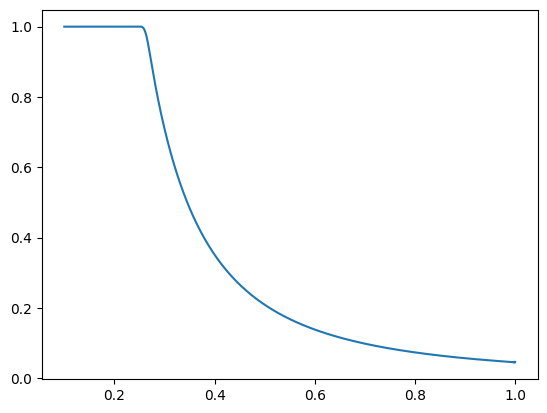

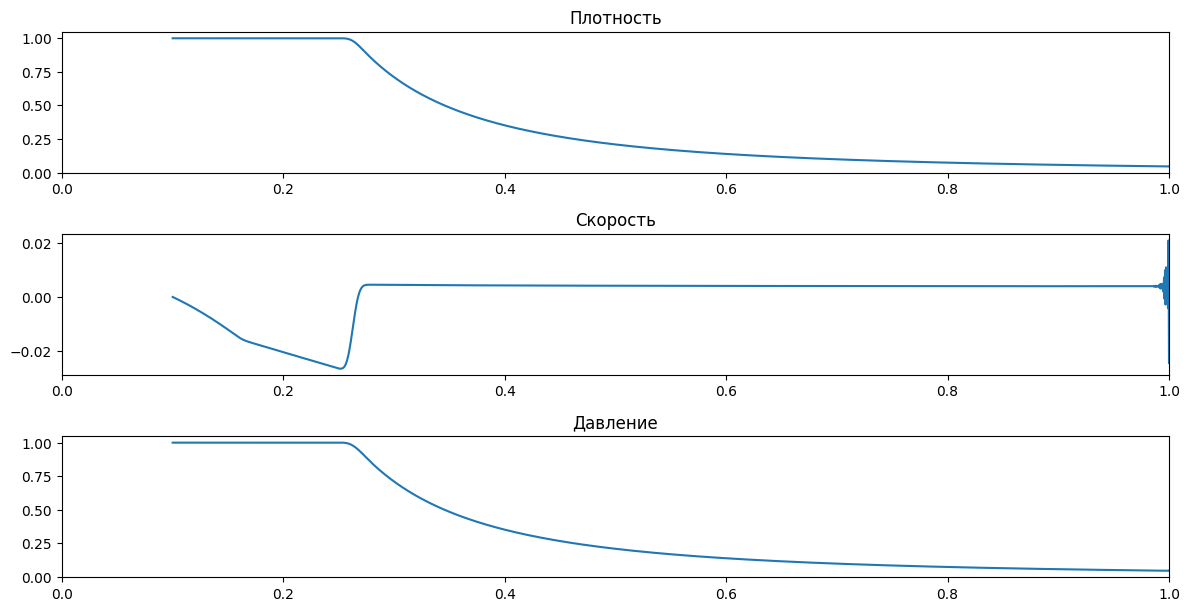

In [42]:

import numpy as np
import matplotlib.pyplot as plt
pi = np.pi

# Constants
gamma = 1.4
t_final = float(input())
Nx = 2000
R_inner = 0.1
x = np.linspace(R_inner, 1.0, Nx)
print('x:', x)
dx = (1.0-R_inner) / Nx
rho_l = 1.0
u_l = 0.0
p_l = 1.0
rho_r = 0.125
u_r = 0.0
p_r = 0.1

# Initial conditions
q = np.zeros((3, Nx))
#q[0] = np.where(x < 0.2, rho_l, rho_r)
#q[1] = np.where(x < 0.2, rho_l * u_l, rho_r * u_r)
#q[2] = np.where(x < 0.2, p_l/(gamma-1) + 0.5*rho_l*u_l**2, p_r/(gamma-1) + 0.5*rho_r*u_r**2)
q[0] = np.where(x < 0.2, rho_l, rho_l*0.2**2*pow(x,-2))
q[1] = np.where(x < 0.2, rho_l * u_l, rho_r * u_l*0.2**2*pow(x,-2))
q[2] = np.where(x < 0.2, p_l/(gamma-1) + 0.5*rho_l*u_l**2, (p_l/(gamma-1) + 0.5*rho_l*u_l**2)*0.2**2*pow(x,-2))
# Flux function
q_left_border = np.array([q[0,0], q[1,0], q[2,0]])
#q_left_border[0] = q[0,0]
#q_left_border[1] = q[1,0]
#q_left_border[2] = q[2,0]
#q_left_border = np.array([1e-9, 0.0, 1e-9])
print('here:', q_left_border.shape, q_left_border)

def flux(q, r = 1): 
    rho = q[0]
    u = q[1] / q[0]
    p = (gamma-1) * (q[2] - 0.5*q[0]*u**2)
    # Ensure rho and p are positive
    rho = np.maximum(rho, 1e-9)
    p = np.maximum(p, 1e-9)
    
    F1 = r**2*q[1]
    F2 = r**2*(q[1]*u + p)
    F3 = r**2*(q[2]+p)*u
    return np.array([rho*u*r**2,(rho*u**2+p)*r**2,u*(q[2]+p)*r**2])


def godunov(q, dx, dt, flag):
    q_half = np.zeros((3, Nx))
    #q_left =  q_left_border
    V_i = dx
    q_half[:, 0] = q_left_border

    for i in range(1, Nx):
        r_i_minus_half = R_inner + (i-1)*dx # Calculating Radius at cell left boundary
        r_i_plus_half = R_inner + (i)*dx  # Calculating Radius at cell right boundary
        r = (r_i_minus_half + r_i_plus_half) / 2
        if i == 0:
            r_i_minus_half = R_inner # Correct for r_i_minus_half
            #V_i = (4/3)*pi*(r_i_plus_half**3 - R_inner**3) # Volume o
            q_left = q[:,i] # Use value from first cell for left boundary
        else:
            V_i = 4*pi*(r_i_plus_half**2 - r_i_minus_half**2)
            q_left = q[:, i - 1]
        
        q_right = q[:, i]
        # Correct the check for q_left to be 3 elements so we can ensure it works with the flux function to create accurate gradients.
        if len(q_left) != 3:
            q_half[:, i] = q[:,i]
            print("><><><><><><><><><><><><><><><><><")
            continue
        
        f_left = flux(q_left)#, r_i_minus_half)
        f_right = flux(q_right)#, r_i_plus_half)
        q_half[:, i] = 0.5*(q[:,i] + q[:, i-1]) - dt/dx *(f_right*r_i_plus_half**2 - f_left*r_i_minus_half**2) #/ r**2
        


    # Update dt
    #Dt = dt*(1-flag) + flag*0.9 * dx / np.max(np.abs(q_half[1]/q_half[0]) + np.sqrt(np.abs(gamma*q_half[2]/q_half[0])))
    return q_half, dt

# Main loop
dt = 0.9 * dx / np.max(np.abs(q[1]/q[0]) + np.sqrt(np.abs(gamma*q[2]/q[0])))

t = 0.0
while t < t_final:
    q_half, dt = godunov(q, dx, dt, 0)
    
    q, dt = godunov(q_half, dx, dt, 1) 
    ##наверное сдвиг из-за того, что одну и ту же функцию 2 раза использую,
    # лучше всё-таки сделать предиктор-корректор со средним значением
    print("#:", dt)
    t += dt
    print('TIME:',t)

print(q[0],q[1],q[2],sep='\n\n')
print('x:',x)

plt.figure()
plt.plot(x, q[0], label='Density')

#plt.plot(x, q[1]/q[0], label='Velocity')
#plt.plot(x, (gamma-1)*(q[2] - 0.5*q[1]**2/q[0]), label='Pressure')
#plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(x,  q[0], label='Плотность')
plt.xlim([0.0, 1.0])
plt.title('Плотность')
plt.subplot(4, 1, 2)
plt.plot(x,  q[1]/q[0], label='Скорость')
plt.xlim([0.0, 1.0])
plt.title('Скорость')
plt.subplot(4, 1, 3)
plt.plot(x, (gamma-1)*(q[2] - 0.5*q[1]**2/q[0]), label='Давление')
plt.xlim([0.0, 1.0])
plt.title('Давление')
#plt.subplot(4, 1, 4)
#plt.plot(x, (gamma-1)*(q[2][0:Nx] - 0.5*q[1][0:Nx]**2/q[0][0:Nx])/q[0][0:Nx], label = 'Температура')
#plt.title('Температура')
plt.tight_layout()
plt.show()


Time: 0.0008
Time: 0.0012
Time: 0.0016
Time: 0.0021
Time: 0.0025
Time: 0.0030
Time: 0.0035
Time: 0.0040
Time: 0.0044
Time: 0.0049
Time: 0.0054
Time: 0.0059
Time: 0.0064
Time: 0.0069
Time: 0.0074
Time: 0.0079
Time: 0.0084
Time: 0.0089
Time: 0.0094
Time: 0.0099
Time: 0.0104
Time: 0.0109
Time: 0.0114
Time: 0.0119
Time: 0.0124
Time: 0.0129
Time: 0.0134
Time: 0.0139
Time: 0.0144
Time: 0.0149
Time: 0.0154
Time: 0.0159
Time: 0.0164
Time: 0.0169
Time: 0.0174
Time: 0.0179
Time: 0.0184
Time: 0.0189
Time: 0.0194
Time: 0.0199
Time: 0.0204
Time: 0.0209
Time: 0.0214
Time: 0.0219
Time: 0.0224
Time: 0.0229
Time: 0.0234
Time: 0.0239
Time: 0.0244
Time: 0.0249
Time: 0.0254
Time: 0.0259
Time: 0.0264
Time: 0.0270
Time: 0.0275
Time: 0.0280
Time: 0.0285
Time: 0.0290
Time: 0.0295
Time: 0.0300
Time: 0.0305
Time: 0.0310
Time: 0.0315
Time: 0.0320
Time: 0.0325
Time: 0.0330
Time: 0.0335
Time: 0.0340
Time: 0.0345
Time: 0.0350
Time: 0.0355
Time: 0.0360
Time: 0.0365
Time: 0.0370
Time: 0.0376
Time: 0.0381
Time: 0.0386

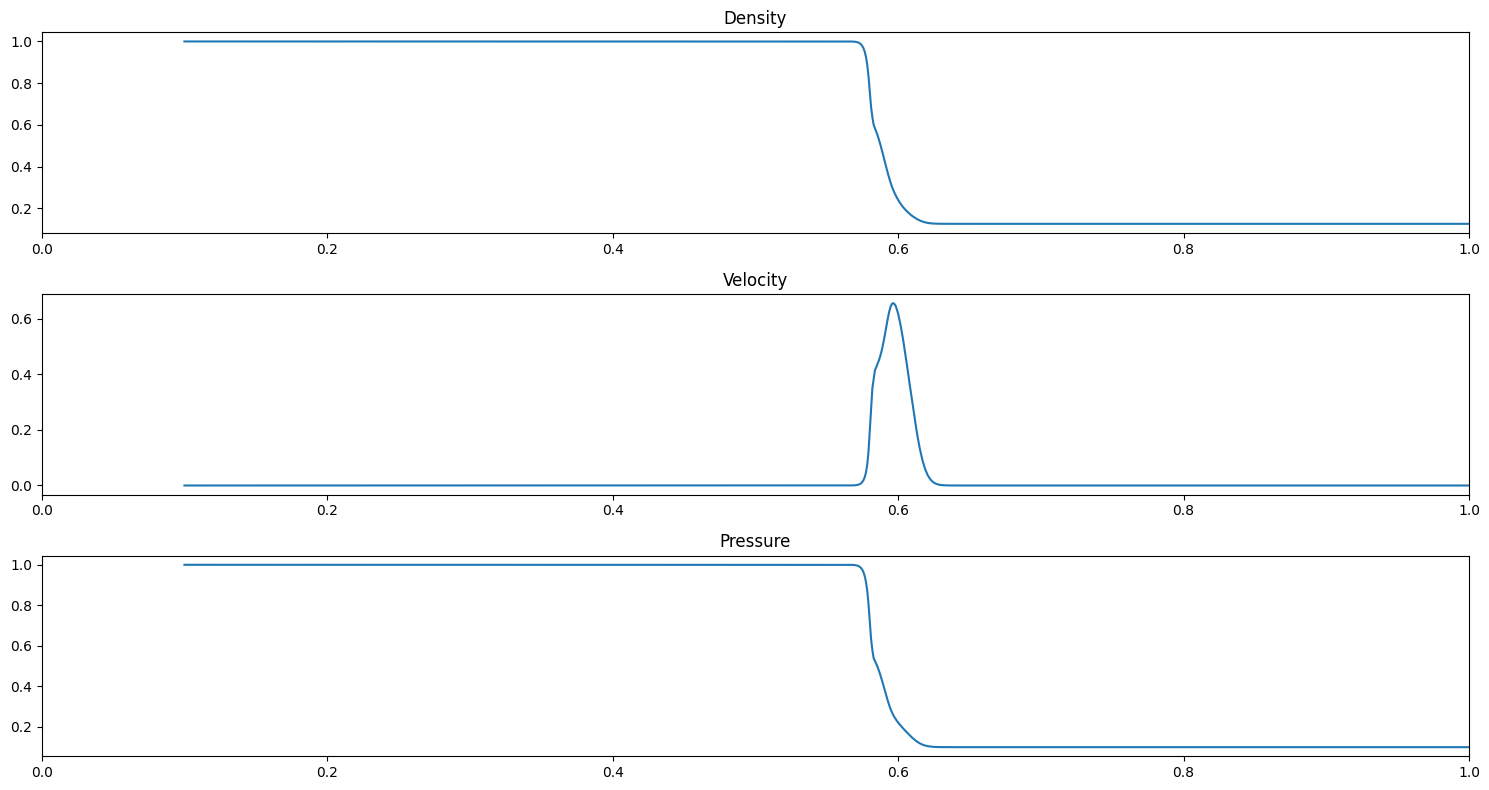

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
gamma = 1.4
t_final = float(input("Enter final time: "))
Nx = 1000
dx = 1.0 / Nx
x = np.linspace(0.1, 1.0, Nx)
rho_l = 1.0
u_l = 0.0
p_l = 1.0
rho_r = 0.125
u_r = 0.0
p_r = 0.1
CFL = 0.9  # Courant number

# Initial conditions
q = np.zeros((3, Nx))
q[0] = np.where(x < 0.5, rho_l, rho_r)
q[1] = np.where(x < 0.5, rho_l * u_l, rho_r * u_r)
q[2] = np.where(x < 0.5, p_l/(gamma-1) + 0.5*rho_l*u_l**2, p_r/(gamma-1) + 0.5*rho_r*u_r**2)

# Minmod limiter
def minmod(a, b):
    if a * b <= 0:
        return 0.0
    elif abs(a) < abs(b):
        return a
    else:
        return b

def flux(q):
    rho = q[0]
    u = q[1] / q[0]
    p = (gamma - 1) * (q[2] - 0.5 * rho * u**2)

    # Ensure rho and p are positive
    rho = np.maximum(rho, 1e-9)
    p = np.maximum(p, 1e-9)

    F1 = q[1]
    F2 = q[1] * u + p
    F3 = (q[2] + p) * u
    return np.array([F1, F2, F3])

def godunov(q, dx, dt):
    q_half = np.zeros((3, Nx))

    for i in range(Nx):
        if i == 0:
            q_left = q[:, 0]
        else:
            q_left = q[:, i-1]
        q_right = q[:, i]

        # Apply minmod limiter
        dq_left = q[:, i] - q[:, i-1] if i > 0 else np.zeros(3)
        dq_right = q[:, i+1] - q[:, i] if i < Nx-1 else np.zeros(3)
        dq_limited = np.array([minmod(dq_left[j], dq_right[j]) for j in range(3)])

        q_left_limited = q[:, i-1] + 0.5 * dq_limited if i > 0 else q[:, 0]
        q_right_limited = q[:, i] - 0.5 * dq_limited

        f_left = flux(q_left_limited)
        f_right = flux(q_right_limited)

        q_half[:, i] = 0.5 * (q_left + q_right - dt/dx * (f_right - f_left))
        q_half[:, i] = np.maximum(q_half[:, i], 0.0)

    return q_half


# Main loop
t = 0.0
while t < t_final:
    # Calculate adaptive time step (CFL condition)
    u = q[1] / q[0]
    p = (gamma - 1) * (q[2] - 0.5 * q[0] * u**2)
    a = np.sqrt(gamma * p / q[0])  # Speed of sound
    max_speed = np.max(np.abs(u) + a)
    dt = CFL * dx / max_speed
    if t + dt > t_final:
        dt = t_final - t


    q_half = godunov(q, dx, dt)
    q = godunov(q_half, dx, dt)


    t += dt
    print(f"Time: {t:.4f}")

# Post-processing and plotting

rho = q[0]
u = q[1] / q[0]
p = (gamma - 1) * (q[2] - 0.5 * q[0] * u**2)

fig, axs = plt.subplots(3, 1, figsize=(15, 8))

axs[0].plot(x, rho)
axs[0].set_title("Density")
axs[0].set_xlim(0, 1)

axs[1].plot(x, u)
axs[1].set_title("Velocity")
axs[1].set_xlim(0, 1)

axs[2].plot(x, p)
axs[2].set_title("Pressure")
axs[2].set_xlim(0, 1)

plt.tight_layout()
plt.show()